# BiGSLICE results

In [10]:
import os
import pandas as pd
import sqlite3
import yaml
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [3]:
# Write samples.csv table to config directory of qc_strepto_ncbi project
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "mq_strepto"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

gtdb_meta_table = processed_dir_1 / "tables"/ "df_gtdb_meta_curated.csv"
df_gtdb_meta = pd.read_csv(gtdb_meta_table, index_col= 0)

seqfu_meta_table = processed_dir_1 / "tables"/ "df_seqfu_stats.csv"
df_seqfu_meta = pd.read_csv(seqfu_meta_table, index_col= 0)

mash_table = processed_dir_1 / "mash"/ "df_mash.csv"
df_mash = pd.read_csv(mash_table, index_col= 0)

df_clusters = pd.read_csv("assets/tables/df_clusters.csv", index_col=0)

filters_table = processed_dir_1 / "tables" / "df_filters.csv"
df_filter_quality = pd.read_csv(filters_table, index_col=0)

antismash_summary_table = processed_dir_1 / "tables" / "df_antismash_7.0.0_summary.csv"
df_antismash_summary = pd.read_csv(antismash_summary_table, index_col=0, low_memory=False)

bgcs_summary_table = processed_dir_1 / "tables" / "df_regions_antismash_7.0.0.csv"
df_bgcs_antismash = pd.read_csv(bgcs_summary_table, index_col=0)

arts_table = processed_dir_1 / "tables" / "df_arts_as-7.0.0.csv"
df_arts = pd.read_csv(arts_table, index_col=0)
df_clusters["Subcluster_label"] = df_clusters.Subcluster_label.fillna("NA")
df_clusters["Cluster_label"] = df_clusters.Subcluster_label.fillna("NA")
# df_getphylo_clusters = pd.read_csv(processed_dir_1 / "iTOL" / 'df_phylo_colored_range_kmeans_getphylo.csv',index_col=0)

In [4]:
# Read bigslice results
df_gcf_presence = pd.read_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_gcf_presence_combined.csv", index_col=0)
df_gcfs_bigslice = pd.read_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_gcfs_combined.csv",index_col=0) 
df_bgcs_bigslice = pd.read_csv(processed_dir_1 / "bigslice" / "cluster_as_7.0.0" / "df_bgcs_curated_with_combined.csv", index_col=0) 

## Phylogroup signature BGCs

In [62]:
df_genomes = pd.DataFrame(columns=["Subcluster"])
df_subcluster = df_clusters[df_clusters.Subcluster_label != "NA"]
df_genomes["Subcluster"] = df_clusters.loc[df_subcluster.index,"Subcluster_label"]
df_bgcs = df_gcf_presence.loc[df_genomes.index, :]
df_bgcs = df_bgcs.applymap(lambda x: 1 if x > 0 else 0)

# Set a threshold for minimum presence across all genomes
threshold = 0.3

# Merge the DataFrames
merged_df = df_genomes.join(df_bgcs)

# Define the minimum cluster size
min_cluster_size = 20

# Group by cluster and filter
filtered_clusters_df = merged_df.groupby('Subcluster').filter(lambda x: len(x) >= min_cluster_size)

def signature_bgcs(cluster_group, overall_presence, min_count=10):
    cluster_size = len(cluster_group)
    bgc_counts = cluster_group.drop(columns=['Subcluster']).sum()
    # Consider BGCs that are present in more than the threshold proportion within the cluster
    # and are rare or absent in the others
    
    signature_bgcs = bgc_counts[(bgc_counts > min_count) & (bgc_counts == overall_presence)]
    return signature_bgcs.index.tolist()

# Calculate overall presence for each BGC across all genomes
overall_presence = filtered_clusters_df.drop(columns=['Subcluster']).sum(axis=0)

# Group by cluster and apply the signature_bgcs function
clusters = filtered_clusters_df.groupby('Subcluster')

min_count = 5
signature_bgcs_per_cluster = clusters.apply(lambda x: signature_bgcs(x, overall_presence, min_count))

all_signature_bgcs = []
for phylogroup in filtered_clusters_df.Subcluster.unique():
    bgc_list = signature_bgcs_per_cluster[phylogroup]
    all_signature_bgcs = all_signature_bgcs + bgc_list
# all_signature_bgcs = list(set(all_signature_bgcs))

df_signature_gcfs = pd.DataFrame(index=all_signature_bgcs, columns=["phylogroup", "color", "genomes"])

for phylogroup in filtered_clusters_df.Subcluster.unique():
    bgc_list = signature_bgcs_per_cluster[phylogroup]
    for gcf in bgc_list:
        df_bigslice_selected = df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined_id == str(gcf)]
        df_signature_gcfs.loc[gcf, "phylogroup"] = phylogroup
        df_signature_gcfs.loc[gcf, "color"] = df_subcluster[df_subcluster.Cluster == int(phylogroup.split("_")[1])].Cluster_Color[0]
        
        df_signature_gcfs.loc[gcf, "genomes"] = len(df_bigslice_selected.genome_id.unique())

for col in df_gcfs_bigslice.columns:
    df_signature_gcfs[col] = df_gcfs_bigslice.loc[df_signature_gcfs.index, col]

df_bgcs_bigslice["gcf_id"] = [str(gcf_id) for gcf_id in df_bgcs_bigslice.gcf_id]
df_signature_gcfs_known = df_signature_gcfs[df_signature_gcfs.known == "Known"]

In [8]:
df_signature_bgcs = df_bgcs_bigslice[df_bgcs_bigslice.gcf_id.isin(df_signature_gcfs.index)]
df_signature_bgcs = df_signature_bgcs.merge(df_bgcs_antismash.loc[df_signature_bgcs.index, :],  left_on="bgc_id", right_index=True)
df_signature_bgcs.to_csv("assets/tables/df_signature_bgcs.csv")
df_signature_gcfs.to_csv("assets/tables/df_signature_gcfs.csv")

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [9]:
df_gcf_presence = (df_gcf_presence > 0).astype(int) 

In [ ]:
# df_genomes = pd.DataFrame(index=df_clusters.index, columns=["Mash_species"])
# df_genomes["Mash_species"] = df_clusters["Mash_species"]
# df_bgcs = df_gcf_presence.loc[df_genomes.index, :]
# df_bgcs = df_bgcs.applymap(lambda x: 1 if x > 0 else 0)

# # Set a threshold for minimum presence across all genomes
# threshold = 0.3

# # Merge the DataFrames
# merged_df = df_genomes.join(df_bgcs)

# # Define the minimum cluster size
# min_species_size = 5

# # Group by species and filter
# filtered_species_df = merged_df.groupby('Mash_species').filter(lambda x: len(x) >= min_species_size)

# # min_count = 10
# def signature_bgcs(cluster_group, overall_presence, threshold=0.3):
#     cluster_size = len(cluster_group)
#     min_count = 3
#     bgc_counts = cluster_group.drop(columns=['Mash_species']).sum()
#     # Consider BGCs that are present in more than the threshold proportion within the cluster
#     # and are rare or absent in the others
    
#     signature_bgcs = bgc_counts[(bgc_counts > min_count) & (bgc_counts == overall_presence)]
#     return signature_bgcs.index.tolist()

# # Calculate overall presence for each BGC across all genomes
# overall_presence = filtered_species_df.drop(columns=['Mash_species']).sum(axis=0)

# # Group by species and apply the signature_bgcs function
# species = filtered_species_df.groupby('Mash_species')
# signature_bgcs_per_species = species.apply(lambda x: signature_bgcs(x, overall_presence, threshold))

# all_species_signature_bgcs = []
# for species in filtered_species_df.Mash_species.unique():
#     bgc_list = signature_bgcs_per_species[species]
#     all_species_signature_bgcs = all_species_signature_bgcs + bgc_list
# all_species_signature_bgcs = list(set(all_species_signature_bgcs))

# df_species_signature_gcfs = pd.DataFrame(index=all_species_signature_bgcs, columns=["species", "color", "genomes", "bgcs", "known_cluster_count", "top_known_cluster", "manual_label"])

# # replace_knonw_dict = {"surugamide A/surugamide D": "surugamide",
# #                       "leupeptin Pr/leupeptin Ac": "leupeptin",
# #                       "diisonitrile antibiotic SF2768": "SF2768",
# #                       "isatropolone A/isotropolone B/isotropolone C": "isatropolone",
# #                       "montamide A/capsimycin/clifednamide A/frontalamide A/combamide A": "montamide",
# #                       "legonoxamine A/desferrioxamine B/legonoxamine B": "legonoxamine",
# #                       "SGR PTMs/SGR PTM Compound b/SGR PTM Compound c/SGR PTM Compound d": "SGR PTM",
# #                       "5-dimethylallylindole-3-acetonitrile" : "5-DMAIAN",
# #                       "flaviolin/1,3,6,8-tetrahydroxynaphthalene": "tetrahydroxynaphthalene"}

# for species in filtered_species_df.Mash_species.unique():
#     bgc_list = signature_bgcs_per_species[species]
#     for gcf in bgc_list:
#         df_bigslice_selected = df_bgcs_bigslice[df_bgcs_bigslice.gcf_id == str(gcf)]
#         df_species_signature_gcfs.loc[gcf, "species"] = species
#         df_species_signature_gcfs.loc[gcf, "color"] = df_subcluster[df_subcluster.Cluster == int(phylogroup.split("_")[1])].Cluster_Color[0]
        
#         df_signature_gcfs.loc[gcf, "genomes"] = len(df_bigslice_selected.genome_id.unique())
#         df_signature_gcfs.loc[gcf, "bgcs"] = df_bigslice_selected.shape[0]
    
#         df_antismash_selected = df_bgcs_antismash.loc[df_bigslice_selected.index, :]
#         df_antismash_selected = df_antismash_selected[df_antismash_selected.similarity > 0.5]
        
#         known_cluster_count =  df_antismash_selected.most_similar_known_cluster_description.value_counts()    
#         df_signature_gcfs.loc[gcf, "known_cluster_count"] = len(known_cluster_count)
#         if len(known_cluster_count) > 0:
#             known_cluster_name = known_cluster_count.index[0]
#             df_signature_gcfs.loc[gcf, "top_known_cluster"] = known_cluster_name
#             if known_cluster_name in replace_knonw_dict.keys():
#                 df_signature_gcfs.loc[gcf, "manual_label"] = replace_knonw_dict[known_cluster_name]
#             else:
#                 df_signature_gcfs.loc[gcf, "manual_label"] = known_cluster_name
#         else:
#             df_signature_gcfs.loc[gcf, "top_known_cluster"] = "Unknown"
#             df_signature_gcfs.loc[gcf, "manual_label"] = ""

# Presence of GCFs specific to subphylgroups

<Figure size 500x500 with 0 Axes>

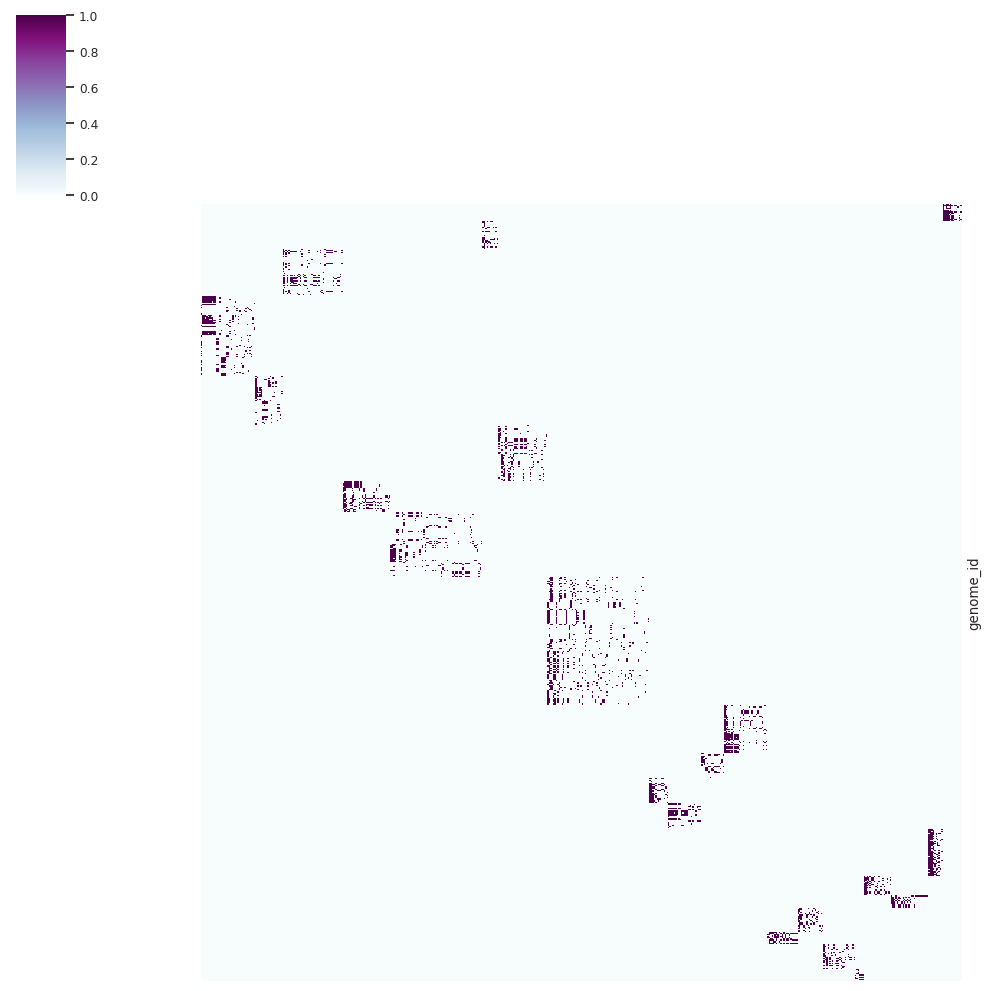

In [11]:
df_signature_gcfs_unknown = df_signature_gcfs[df_signature_gcfs.known == "Unknown"]
filtered_clusters_df.sort_values(by="Subcluster",inplace=True)
df_heatmap = df_gcf_presence.loc[filtered_clusters_df.index, df_signature_gcfs_unknown.index]
df_heatmap.columns = df_signature_gcfs_unknown.gcf_combined_name.tolist()

df_colors = df_clusters.loc[df_heatmap.index, ["Cluster_Color", "Subcluster_Color"]]
plt.figure(figsize=(5,5))
sns.set(font_scale=0.8)
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               # row_colors=df_colors, 
               row_cluster=False, col_cluster=False,
               xticklabels=False, yticklabels=False)

<Figure size 500x500 with 0 Axes>

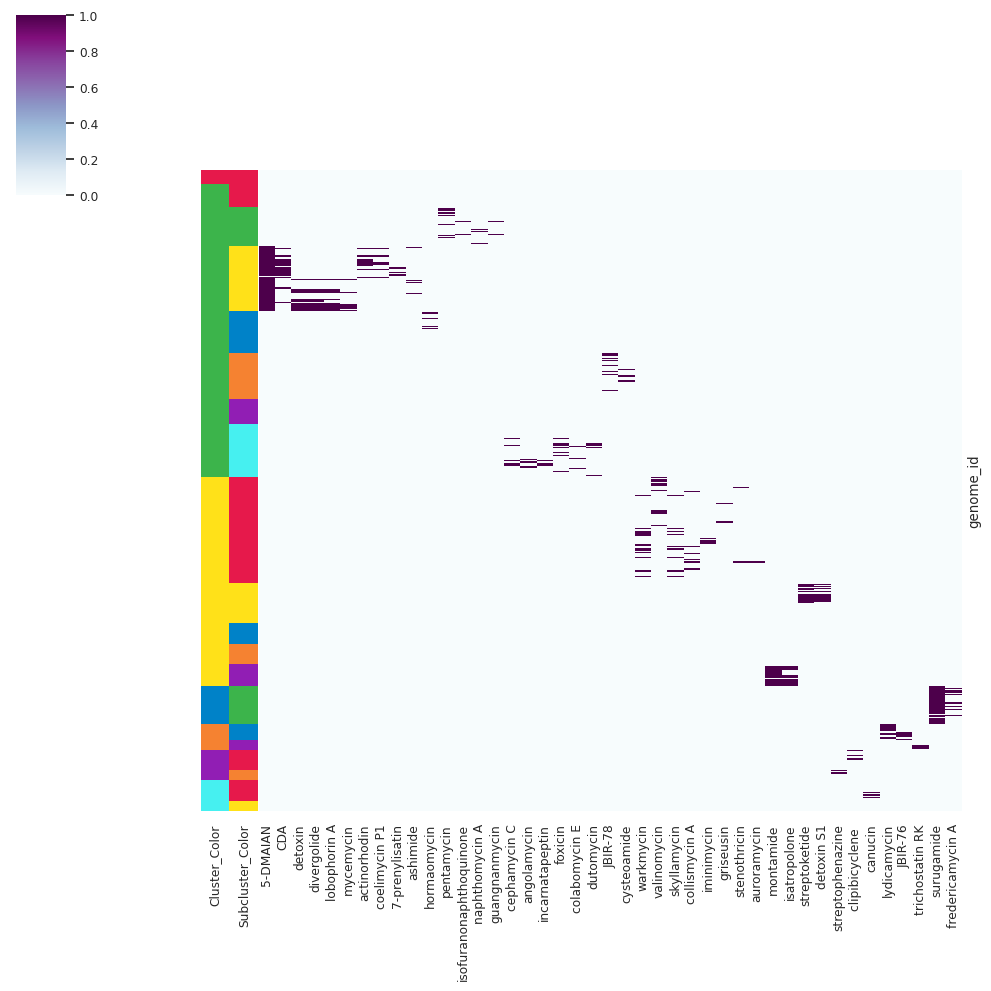

In [12]:
filtered_clusters_df.sort_values(by="Subcluster",inplace=True)
df_heatmap = df_gcf_presence.loc[filtered_clusters_df.index, df_signature_gcfs_known.index]
df_heatmap.columns = df_signature_gcfs_known.gcf_combined_name.tolist()
df_heatmap = (df_heatmap > 0).astype(int) 

df_colors = df_clusters.loc[df_heatmap.index, ["Cluster_Color", "Subcluster_Color"]]
plt.figure(figsize=(5,5))
sns.set(font_scale=0.8)
sns.clustermap(df_heatmap, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, 
               row_cluster=False, col_cluster=False,
               xticklabels=True, yticklabels=False)

<Figure size 1000x1200 with 0 Axes>

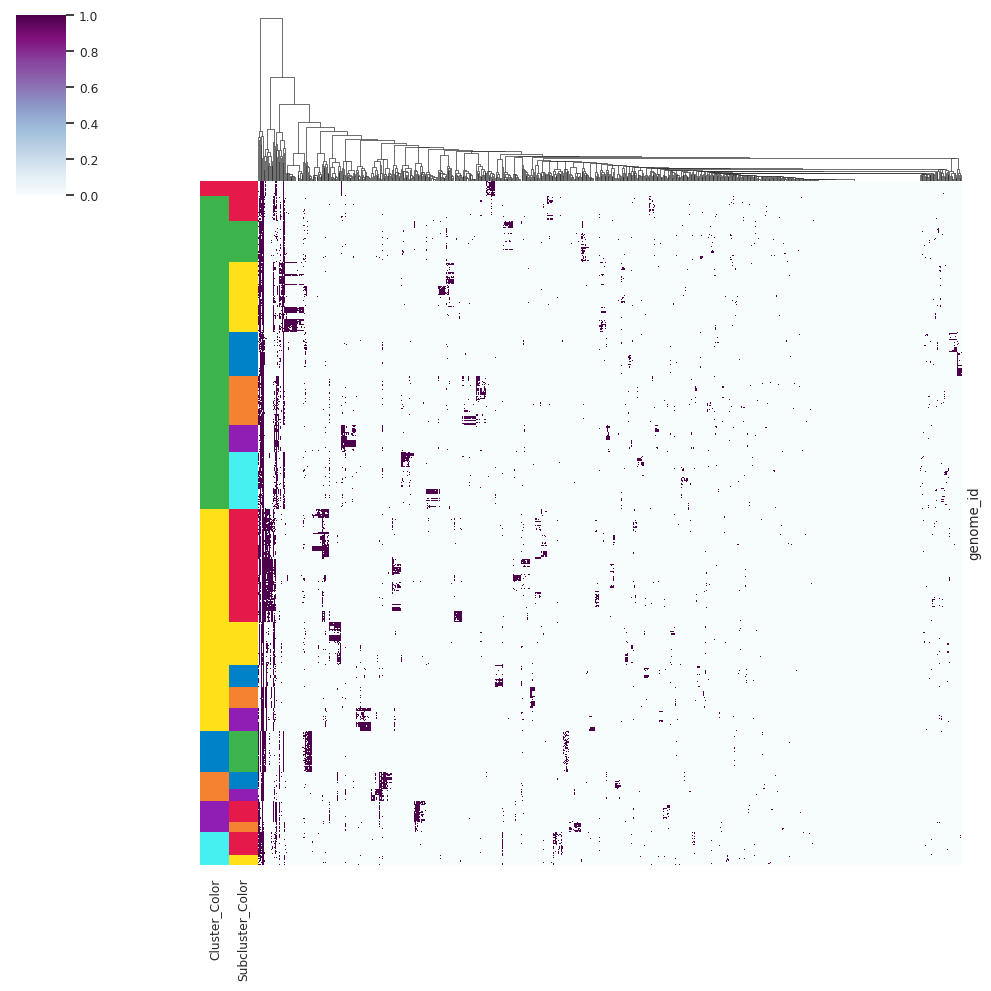

In [77]:
df_gcf_abundant = df_gcf_presence.loc[:,df_gcf_presence.sum() > 10]

df_plot = df_gcf_presence.loc[filtered_clusters_df.index,df_gcf_abundant.columns]
df_colors = df_clusters.loc[df_plot.index, ["Cluster_Color", "Subcluster_Color"]]
plt.figure(figsize=(10,12))
sns.set(font_scale=0.8)
sns.clustermap(df_plot, 
               metric="euclidean", method="ward", cmap="BuPu",
               row_colors=df_colors, 
               row_cluster=False, col_cluster=True,
               xticklabels=False, yticklabels=False)

In [48]:
df_signature_bgcs_unknown = df_signature_bgcs[df_signature_bgcs.gcf_combined_id.isin(df_signature_gcfs_unknown.index)]

In [51]:
df_signature_bgcs_unknown_known = df_signature_bgcs_unknown[df_signature_bgcs_unknown.similarity > 0.6]
# df_signature_gcfs_unknown
# df_signature_gcfs_known
df_signature_bgcs_unknown_known.gcf_combined_id.value_counts()

gcf_combined_id
6467     46
8213     45
8833     41
9148     35
4743     31
         ..
9423      1
1508      1
9608      1
11343     1
1946      1
Name: count, Length: 64, dtype: int64

In [57]:
df_signature_gcfs.known.value_counts()

known
Unknown    529
Known       43
Name: count, dtype: int64

In [56]:
df_signature_bgcs_unknown_known.most_similar_known_cluster_description.value_counts().shape

(37,)

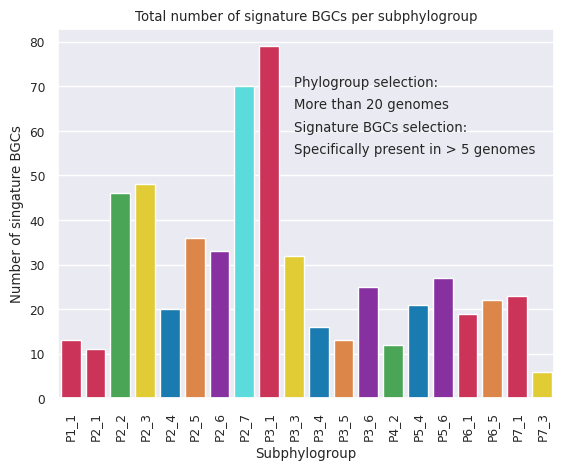

In [22]:
# Plot barplot across phylogroups
cluster_counts = df_signature_gcfs.groupby('phylogroup').size().reset_index(name='count')

# Create a dictionary mapping clusters to colors
color_mapping = dict(zip(df_signature_gcfs['phylogroup'], df_signature_gcfs['color']))

# Use the palette argument to set the colors
plot = sns.barplot(x='phylogroup', y='count', data=cluster_counts, palette=color_mapping)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.xlabel('Subphylogroup')
plt.ylabel('Number of singature BGCs')
plt.title('Total number of signature BGCs per subphylogroup')
plt.text(9, 70, f"Phylogroup selection:", ha='left')
plt.text(9, 65, f"More than 20 genomes", ha='left')
plt.text(9, 60, f"Signature BGCs selection:", ha='left')
plt.text(9, 55, f"Specifically present in > 5 genomes", ha='left')
# plt.text(9, 50, f"50% of genomes of the phylogroup", ha='left')

plt.show()

# Create BGC project for selected known cluster representatives across phylogroups

## BGC projects for top known BGCs

In [152]:
df_bgcs_antismash.loc[df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined == "597"].index, :]["most_similar_known_cluster_description"].value_counts()

most_similar_known_cluster_description
schizokinen                                                                                                                              392
synechobactin C9/synechobactin C11/synechobactin 13/synechobactin 14/synechobactin 16/synechobactin A/synechobactin B/synechobactin C    253
meridamycin                                                                                                                                1
Name: count, dtype: int64

In [139]:
df_bgc_selected = df_bgcs_antismash[df_bgcs_antismash.most_similar_known_cluster_description == "hopene"]
df_bgc_selected.loc[:, df_bgcs_bigslice.columns] = df_bgcs_bigslice.loc[df_bgc_selected.index,:]
df_bgc_selected = df_bgc_selected.merge(df_clusters, left_on='genome_id', right_index=True)

In [133]:
df_samples = df_bgcs_bigslice.copy()

report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
mapping_dir = report_dir / "log_changes/7.0.0/"
antismash_dir = report_dir / "antismash/7.0.0/"

for i in df_samples.index:
    genome_id = df_samples.loc[i, "genome_id"]
    mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
    with open(mapping_dict, "r") as f:
        mapping_dict = json.load(f)
    for item in mapping_dict[genome_id].values():
        if Path(item['symlinhk_path']).stem == i:
            gbk_file = Path(item['target_path']).name
            gbk_file = antismash_dir / genome_id / gbk_file
            assert gbk_file.is_file()
            df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
            df_samples.loc[i, 'record_id'] = item['record_id']
            df_samples.loc[i, 'original_id'] = item['original_id']
df_samples['source'] = "bgcflow"

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0000271.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0000271/generated/BGC0000271.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0000663', "genome_id"] = 'GCF_000009765.2'
df_samples.loc['BGC0000663', "source"] = 'bgcflow'
df_samples.loc['BGC0000663', "gbk_path"] = gbk_path_mibig.resolve()

File ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0000271.region001.gbk’ already there; not retrieving.


In [136]:
outfile = bgcflow_dir / "config/spore_pigment/samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## BGC project 3: spore_pigment

In [129]:
df_bgc_selected = df_bgcs_antismash[df_bgcs_antismash.most_similar_known_cluster_description == "hopene"]
df_bgc_selected.loc[:, df_bgcs_bigslice.columns] = df_bgcs_bigslice.loc[df_bgc_selected.index,:]
df_bgc_selected = df_bgc_selected.merge(df_clusters, left_on='genome_id', right_index=True)

In [133]:
import json

df_samples = df_bgcs_bigslice.copy()

report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
mapping_dir = report_dir / "log_changes/7.0.0/"
antismash_dir = report_dir / "antismash/7.0.0/"

for i in df_samples.index:
    genome_id = df_samples.loc[i, "genome_id"]
    mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
    with open(mapping_dict, "r") as f:
        mapping_dict = json.load(f)
    for item in mapping_dict[genome_id].values():
        if Path(item['symlink_path']).stem == i:
            gbk_file = Path(item['target_path']).name
            gbk_file = antismash_dir / genome_id / gbk_file
            assert gbk_file.is_file()
            df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
            df_samples.loc[i, 'record_id'] = item['record_id']
            df_samples.loc[i, 'original_id'] = item['original_id']
df_samples['source'] = "bgcflow"

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0000271.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0000271/generated/BGC0000271.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0000271', "genome_id"] = 'GCF_000009765.2'
df_samples.loc['BGC0000271', "source"] = 'bgcflow'
df_samples.loc['BGC0000271', "gbk_path"] = gbk_path_mibig.resolve()

File ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0000271.region001.gbk’ already there; not retrieving.


In [136]:
outfile = bgcflow_dir / "config/spore_pigment/samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## BGC project 2: spore_pigment_align

### Select representative from Cytoscape analysis from each subphylogroup for alignments

In [30]:
df_samples_selected = pd.read_csv(bgcflow_dir / "config/spore_pigment/selected_samples.csv")
df_samples_selected = df_samples_selected[df_samples_selected.select_bgc == "Yes"]
df_samples_align = pd.DataFrame(index=df_samples_selected["shared name"].tolist() + ["BGC0000271"])
df_samples_align.index.name = "bgc_id"
df_samples_align = df_samples.loc[df_samples_align.index,:]
outfile = bgcflow_dir / "config/spore_pigment_align/samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples_align.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## BGC project 3: coelichelin

In [32]:
known_cluster = "coelichelin"
df_selected_gcfs = df_signature_gcfs[df_signature_gcfs.top_known_cluster == known_cluster]
selected_gcfs = [str(gcf_id) for gcf_id in df_selected_gcfs.index.tolist()]
df_selected_bgcs = df_bgcs_bigslice.loc[df_bgcs_bigslice.gcf_id.isin(selected_gcfs), :]

In [34]:
import json

df_samples = df_selected_bgcs.copy()

report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
mapping_dir = report_dir / "log_changes/7.0.0/"
antismash_dir = report_dir / "antismash/7.0.0/"

for i in df_samples.index:
    genome_id = df_samples.loc[i, "genome_id"]
    mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
    with open(mapping_dict, "r") as f:
        mapping_dict = json.load(f)
    for item in mapping_dict[genome_id].values():
        if Path(item['symlink_path']).stem == i:
            gbk_file = Path(item['target_path']).name
            gbk_file = antismash_dir / genome_id / gbk_file
            assert gbk_file.is_file()
            df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
            df_samples.loc[i, 'record_id'] = item['record_id']
            df_samples.loc[i, 'original_id'] = item['original_id']
df_samples['source'] = "bgcflow"

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0000325.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0000271/generated/BGC0000271.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0000325', "genome_id"] = 'GCF_008931305.1'
df_samples.loc['BGC0000325', "source"] = 'bgcflow'
df_samples.loc['BGC0000325', "gbk_path"] = gbk_path_mibig.resolve()

--2023-08-23 13:57:14--  https://mibig.secondarymetabolites.org/repository/BGC0000271/generated/BGC0000271.gbk
Resolving mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)... 130.226.55.167, 130.226.55.166
Connecting to mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)|130.226.55.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33141 (32K) [application/octet-stream]
Saving to: ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0000325.region001.gbk’

/datadrive/bgcflow/ 100%[===================>]  32.36K  --.-KB/s    in 0s      

2023-08-23 13:57:14 (102 MB/s) - ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0000325.region001.gbk’ saved [33141/33141]



In [35]:
outfile = bgcflow_dir / "config" / known_cluster / "samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [36]:
df_signature_gcfs.top_known_cluster.value_counts()

top_known_cluster
Unknown                                            177
spore pigment                                       19
coelichelin                                         18
isorenieratene                                      14
alkylresorcinol                                     13
                                                  ... 
citrulassin D                                        1
scabichelin                                          1
thaxtomin D/thaxtomin A/thaxtomin C/thaxtomin B      1
bottromycin A2                                       1
antipain                                             1
Name: count, Length: 107, dtype: int64

## BGC project 5: isorenieratene

In [37]:
known_cluster = "isorenieratene"
df_selected_gcfs = df_signature_gcfs[df_signature_gcfs.top_known_cluster == known_cluster]
selected_gcfs = [str(gcf_id) for gcf_id in df_selected_gcfs.index.tolist()]
df_selected_bgcs = df_bgcs_bigslice.loc[df_bgcs_bigslice.gcf_id.isin(selected_gcfs), :]

In [38]:
import json

df_samples = df_selected_bgcs.copy()

report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
mapping_dir = report_dir / "log_changes/7.0.0/"
antismash_dir = report_dir / "antismash/7.0.0/"

for i in df_samples.index:
    genome_id = df_samples.loc[i, "genome_id"]
    mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
    with open(mapping_dict, "r") as f:
        mapping_dict = json.load(f)
    for item in mapping_dict[genome_id].values():
        if Path(item['symlink_path']).stem == i:
            gbk_file = Path(item['target_path']).name
            gbk_file = antismash_dir / genome_id / gbk_file
            assert gbk_file.is_file()
            df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
            df_samples.loc[i, 'record_id'] = item['record_id']
            df_samples.loc[i, 'original_id'] = item['original_id']
df_samples['source'] = "bgcflow"

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0001227.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0000271/generated/BGC0000271.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0001227', "genome_id"] = 'GCF_000444875.1'
df_samples.loc['BGC0001227', "source"] = 'bgcflow'
df_samples.loc['BGC0001227', "gbk_path"] = gbk_path_mibig.resolve()

--2023-08-23 14:04:24--  https://mibig.secondarymetabolites.org/repository/BGC0000271/generated/BGC0000271.gbk
Resolving mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)... 130.226.55.167, 130.226.55.166
Connecting to mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)|130.226.55.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33141 (32K) [application/octet-stream]
Saving to: ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0001227.region001.gbk’

/datadrive/bgcflow/ 100%[===================>]  32.36K  --.-KB/s    in 0s      

2023-08-23 14:04:25 (276 MB/s) - ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0001227.region001.gbk’ saved [33141/33141]



In [39]:
outfile = bgcflow_dir / "config" / known_cluster / "samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [30]:
df_samples_selected = pd.read_csv(bgcflow_dir / "config/spore_pigment/selected_samples.csv")
df_samples_selected = df_samples_selected[df_samples_selected.select_bgc == "Yes"]
df_samples_align = pd.DataFrame(index=df_samples_selected["shared name"].tolist() + ["BGC0000271"])
df_samples_align.index.name = "bgc_id"
df_samples_align = df_samples.loc[df_samples_align.index,:]
outfile = bgcflow_dir / "config/spore_pigment_align/samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples_align.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## BGC project 6: tripartilactam/ BGC0002517 

In [94]:
known_cluster = "tripartilactam"
df_selected_bgcs = df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined_id == "BGC0002517"]
df_selected_bgcs.drop(columns="genome_id", inplace=True)
df_selected_bgcs = df_selected_bgcs.merge(df_bgcs_antismash.loc[df_selected_bgcs.index, :],  left_on="bgc_id", right_index=True)

/tmp/ipykernel_3126/1496686811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_bgcs.drop(columns="genome_id", inplace=True)


In [96]:
import json

df_samples = df_selected_bgcs.copy()

report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
mapping_dir = report_dir / "log_changes/7.0.0/"
antismash_dir = report_dir / "antismash/7.0.0/"

for i in df_samples.index:
    genome_id = df_samples.loc[i, "genome_id"]
    mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
    with open(mapping_dict, "r") as f:
        mapping_dict = json.load(f)
    for item in mapping_dict[genome_id].values():
        if Path(item['symlink_path']).stem == i:
            gbk_file = Path(item['target_path']).name
            gbk_file = antismash_dir / genome_id / gbk_file
            assert gbk_file.is_file()
            df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
            df_samples.loc[i, 'record_id'] = item['record_id']
            df_samples.loc[i, 'original_id'] = item['original_id']
df_samples['source'] = "bgcflow"

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0002517.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0002517/generated/BGC0002517.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0002517', "genome_id"] = 'GCF_000444875.1'
df_samples.loc['BGC0002517', "source"] = 'bgcflow'
df_samples.loc['BGC0002517', "gbk_path"] = gbk_path_mibig.resolve()

--2023-09-02 12:36:14--  https://mibig.secondarymetabolites.org/repository/BGC0002517/generated/BGC0002517.gbk
Resolving mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)... 130.226.55.167, 130.226.55.166
Connecting to mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)|130.226.55.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314530 (307K) [application/octet-stream]
Saving to: ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0002517.region001.gbk’

/datadrive/bgcflow/ 100%[===================>] 307.16K  --.-KB/s    in 0.1s    

2023-09-02 12:36:15 (2.86 MB/s) - ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0002517.region001.gbk’ saved [314530/314530]



## BGC project 7: Rapamycin

In [5]:
known_cluster = "rapamycin"
df_selected_bgcs = df_bgcs_antismash[df_bgcs_antismash.most_similar_known_cluster_id.isin(["BGC0000353", "BGC0000994", "BGC0001040"])].sort_values(by="similarity")
df_selected_bgcs = df_selected_bgcs[df_selected_bgcs.similarity > 0.25]

In [12]:
df_samples = df_selected_bgcs.copy()

report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
mapping_dir = report_dir / "log_changes/7.0.0/"
antismash_dir = report_dir / "antismash/7.0.0/"

for i in df_samples.index:
    genome_id = df_samples.loc[i, "genome_id"]
    mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
    with open(mapping_dict, "r") as f:
        mapping_dict = json.load(f)
    for item in mapping_dict[genome_id].values():
        if Path(item['symlink_path']).stem == i:
            gbk_file = Path(item['target_path']).name
            gbk_file = antismash_dir / genome_id / gbk_file
            assert gbk_file.is_file()
            df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
            df_samples.loc[i, 'record_id'] = item['record_id']
            df_samples.loc[i, 'original_id'] = item['original_id']
df_samples['source'] = "bgcflow"

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0001040.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0001040/generated/BGC0001040.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0001040', "genome_id"] = 'GCF_024298965.1'
df_samples.loc['BGC0001040', "source"] = 'bgcflow'
df_samples.loc['BGC0001040', "gbk_path"] = gbk_path_mibig.resolve()

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0000353.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0000353/generated/BGC0000353.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0000353', "genome_id"] = 'GCF_024298965.1'
df_samples.loc['BGC0000353', "source"] = 'bgcflow'
df_samples.loc['BGC0000353', "gbk_path"] = gbk_path_mibig.resolve()

gbk_path_mibig = bgcflow_dir / "data/external/bgc_selection/MIBIG/BGC0000994.region001.gbk"
gbk_path_mibig.parent.mkdir(parents=True, exist_ok=True)
! wget https://mibig.secondarymetabolites.org/repository/BGC0000994/generated/BGC0000994.gbk -O {gbk_path_mibig} -nc
df_samples.loc['BGC0000994', "genome_id"] = 'GCF_024298965.1'
df_samples.loc['BGC0000994', "source"] = 'bgcflow'
df_samples.loc['BGC0000994', "gbk_path"] = gbk_path_mibig.resolve()

File ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0001040.region001.gbk’ already there; not retrieving.
--2023-09-04 09:22:57--  https://mibig.secondarymetabolites.org/repository/BGC0000353/generated/BGC0000353.gbk
Resolving mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)... 130.226.55.167, 130.226.55.166
Connecting to mibig.secondarymetabolites.org (mibig.secondarymetabolites.org)|130.226.55.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133905 (131K) [application/octet-stream]
Saving to: ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0000353.region001.gbk’

/datadrive/bgcflow/ 100%[===================>] 130.77K  --.-KB/s    in 0.07s   

2023-09-04 09:22:58 (1.80 MB/s) - ‘/datadrive/bgcflow/data/external/bgc_selection/MIBIG/BGC0000353.region001.gbk’ saved [133905/133905]

--2023-09-04 09:22:59--  https://mibig.secondarymetabolites.org/repository/BGC0000994/generated/BGC0000994.gbk
Resolving mibig.secondarymetabolites

In [13]:
outfile = bgcflow_dir / "config" / known_cluster / "samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## BGC project 8: P4_Example

In [19]:
project_name_selected = "p4_example"
selected_bgcs = ["NZ_CP110818.1.region007", "NZ_CP049945.1.region015", "NZ_CP049945.1.region014", "NC_020990.1.region005", "NC_020990.1.region006","CP109245.region017", "NZ_CP031742.1.region008"]
df_selected_bgcs = df_bgcs_antismash.loc[selected_bgcs,:]

In [20]:
df_samples = df_selected_bgcs.copy()

report_dir = bgcflow_dir / f"data/processed/{project_name_1}"
mapping_dir = report_dir / "log_changes/7.0.0/"
antismash_dir = report_dir / "antismash/7.0.0/"

for i in df_samples.index:
    genome_id = df_samples.loc[i, "genome_id"]
    mapping_dict = mapping_dir / f"{genome_id}-change_log.json"
    with open(mapping_dict, "r") as f:
        mapping_dict = json.load(f)
    for item in mapping_dict[genome_id].values():
        if Path(item['symlink_path']).stem == i:
            gbk_file = Path(item['target_path']).name
            gbk_file = antismash_dir / genome_id / gbk_file
            assert gbk_file.is_file()
            df_samples.loc[i, 'gbk_path'] = gbk_file.resolve()
            df_samples.loc[i, 'record_id'] = item['record_id']
            df_samples.loc[i, 'original_id'] = item['original_id']
df_samples['source'] = "bgcflow"

In [21]:
outfile = bgcflow_dir / "config" / project_name_selected / "samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples.to_csv(outfile)

## BGC project 8: Rapamycin_genomes

In [15]:
known_cluster = "rapamycin_genome"
df_selected_bgcs = df_bgcs_antismash[df_bgcs_antismash.most_similar_known_cluster_id.isin(["BGC0000353", "BGC0000994", "BGC0001040"])].sort_values(by="similarity")
df_selected_bgcs = df_selected_bgcs[df_selected_bgcs.similarity > 0.25]
df_samples = pd.read_csv(bgcflow_dir / "config"/ "mq_strepto" / "samples.csv", index_col=0)
df_samples = df_samples.loc[df_selected_bgcs.genome_id.unique(), :]
df_samples

,source,organism,genus,species,strain,closest_placement_reference
genome_id,,,,,,
GCF_026341515.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_002591335.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_002812405.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_006974005.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_017874715.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_014205315.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_003932715.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_007856155.1,ncbi,NaN,NaN,NaN,NaN,NaN
GCF_000297155.3,ncbi,NaN,NaN,NaN,NaN,NaN


In [16]:
outfile = bgcflow_dir / "config" / known_cluster / "samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


# Top PKS projects

In [56]:
df_known_pks = df_gcfs_bigslice[(df_gcfs_bigslice.top_known_cluster_category == "Polyketide")]

In [69]:
df_selected_bgcs = df_bgcs_antismash[df_bgcs_antismash.most_similar_known_cluster_id.isin(["BGC0001070"])].sort_values(by="similarity")
df_selected_bgcs = df_selected_bgcs[df_selected_bgcs.similarity > 0.25]

In [38]:
df_selected_bgcs = df_bgcs_bigslice[df_bgcs_bigslice.gcf_combined == "fuelimycin"]
df_selected_bgcs.known_cluster_blast_name = df_selected_bgcs.known_cluster_blast_name.fillna("NA")
# df_bgcs_antismash.loc[df_selected_bgcs.index,:].gcf_combined.value_counts()
df_selected_bgcs.groupby(by=["gcf_id", "known_cluster_blast_name"]).count()

/tmp/ipykernel_77002/3336688782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_bgcs.known_cluster_blast_name = df_selected_bgcs.known_cluster_blast_name.fillna("NA")


dataset_id  name  type  \
gcf_id known_cluster_blast_name                                         
7414   NA                                             382   382   382   
       fuelimycin A/fuelimicin B/fuelimicin C           1     1     1   
       tetrafibricin                                    1     1     1   
8513   fuelimycin A/fuelimicin B/fuelimicin C           1     1     1   
8995   fuelimycin A/fuelimicin B/fuelimicin C           1     1     1   
9056   fuelimycin A/fuelimicin B/fuelimicin C           1     1     1   
9585   fuelimycin A/fuelimicin B/fuelimicin C           2     2     2   
10347  fuelimycin A/fuelimicin B/fuelimicin C           7     7     7   
11187  NA                                               1     1     1   
       fuelimycin A/fuelimicin B/fuelimicin C           1     1     1   

                                               on_contig_edge  length_nt  \
gcf_id known_cluster_blast_name                                            
7414   NA                                                 382        382   
       fuelimycin A/fuelimicin B/fuelimicin C               1          1   
       tetrafibricin                                        1          1   
8513   fuelimycin A/fuelimicin B/fuelimicin C               1          1   
8995   fuelimycin A/fuelimicin B/fuelimicin C               1          1   
9056   fuelimycin A/fuelimicin B/fuelimicin C               1          1   
9585   fuelimycin A/fuelimicin B/fuelimicin C               2          2   
10347  fuelimycin A/fuelimicin B/fuelimicin C               7          7   
11187  NA                                                   1          1   
       fuelimycin A/fuelimicin B/fuelimicin C               1          1   

                                               orig_folder  orig_filename  \
gcf_id known_cluster_blast_name                                             
7414   NA                                              382            382   
       fuelimycin A/fuelimicin B/fuelimicin C            1              1   
       tetrafibricin                                     1              1   
8513   fuelimycin A/fuelimicin B/fuelimicin C            1              1   
8995   fuelimycin A/fuelimicin B/fuelimicin C            1              1   
9056   fuelimycin A/fuelimicin B/fuelimicin C            1              1   
9585   fuelimycin A/fuelimicin B/fuelimicin C            2              2   
10347  fuelimycin A/fuelimicin B/fuelimicin C            7              7   
11187  NA                                                1              1   
       fuelimycin A/fuelimicin B/fuelimicin C            1              1   

                                               genome_id  membership_value  \
gcf_id known_cluster_blast_name                                              
7414   NA                                            382               382   
       fuelimycin A/fuelimicin B/fuelimicin C          1                 1   
       tetrafibricin                                   1                 1   
8513   fuelimycin A/fuelimicin B/fuelimicin C          1                 1   
8995   fuelimycin A/fuelimicin B/fuelimicin C          1                 1   
9056   fuelimycin A/fuelimicin B/fuelimicin C          1                 1   
9585   fuelimycin A/fuelimicin B/fuelimicin C          2                 2   
10347  fuelimycin A/fuelimicin B/fuelimicin C          7                 7   
11187  NA                                              1                 1   
       fuelimycin A/fuelimicin B/fuelimicin C          1                 1   

                                               known_cluster_blast  \
gcf_id known_cluster_blast_name                                      
7414   NA                                                        0   
       fuelimycin A/fuelimicin B/fuelimicin C                    1   
       tetrafibricin                                             1   
8513   fuelimycin A/fuelimicin B/fuelimicin C

In [41]:
known_cluster = "fuelimycin"
df_selected_bgcs = df_bgcs_antismash[df_bgcs_antismash.most_similar_known_cluster_id.isin(["BGC0002138", "BGC0001002"])].sort_values(by="similarity")
df_selected_bgcs = df_selected_bgcs[df_selected_bgcs.similarity > 0.25]

,genome_id,region,accession,start_pos,end_pos,contig_edge,product,region_length,most_similar_known_cluster_id,most_similar_known_cluster_description,most_similar_known_cluster_type,similarity,source,gbk_path
bgc_id,,,,,,,,,,,,,,
NZ_FNVU01000001.1.region003,GCF_900107965.1,32.30,NZ_FNVU01000001.1,342978,387172,False,['T1PKS'],44194,BGC0001002,jawsamycin,NRP+Polyketide,0.333333,bgcflow,data/interim/antismash/7.0.0/GCF_900107965.1/N...
CP108318.region037,NBC_00003,1.37,CP108318,8488517,8550484,False,"['NRPS', 'T1PKS']",61967,BGC0002138,fuelimycin A/fuelimicin B/fuelimicin C,Polyketide,0.400000,bgcflow,data/interim/antismash/7.0.0/NBC_00003/CP10831...
CP107913.region011,NBC_00448,1.11,CP107913,2803934,2845215,False,['T1PKS'],41281,BGC0001002,jawsamycin,NRP+Polyketide,0.444444,bgcflow,data/interim/antismash/7.0.0/NBC_00448/CP10791...
CP109018.region020,NBC_00669,1.20,CP109018,6824027,6868224,False,['T1PKS'],44197,BGC0001002,jawsamycin,NRP+Polyketide,0.444444,bgcflow,data/interim/antismash/7.0.0/NBC_00669/CP10901...
NZ_BMVP01000015.1.region001,GCF_014650775.1,15.10,NZ_BMVP01000015.1,84507,128461,False,['T1PKS'],43954,BGC0002138,fuelimycin A/fuelimicin B/fuelimicin C,Polyketide,1.000000,bgcflow,data/interim/antismash/7.0.0/GCF_014650775.1/N...
NZ_CP097123.1.region022,GCF_023330645.1,1.22,NZ_CP097123.1,3769465,3815260,False,"['ectoine', 'T1PKS']",45795,BGC0002138,fuelimycin A/fuelimicin B/fuelimicin C,Polyketide,1.000000,bgcflow,data/interim/antismash/7.0.0/GCF_023330645.1/N...
NZ_JAOAQK010000001.1.region011,GCF_029617805.1,1.11,NZ_JAOAQK010000001.1,3347885,3458208,False,"['NRPS-like', 'arylpolyene', 'ladderane', 'T1P...",110323,BGC0002138,fuelimycin A/fuelimicin B/fuelimicin C,Polyketide,1.000000,bgcflow,data/interim/antismash/7.0.0/GCF_029617805.1/N...
NZ_CP124863.1.region026,GCF_030028635.1,1.26,NZ_CP124863.1,6555027,6635104,False,"['T1PKS', 'prodigiosin']",80077,BGC0002138,fuelimycin A/fuelimicin B/fuelimicin C,Polyketide,1.000000,bgcflow,data/interim/antismash/7.0.0/GCF_030028635.1/N...
CP109019.region006,NBC_00668,1.60,CP109019,819410,904697,False,"['T1PKS', 'prodigiosin', 'amglyccycl']",85287,BGC0002138,fuelimycin A/fuelimicin B/fuelimicin C,Polyketide,1.000000,bgcflow,data/interim/antismash/7.0.0/NBC_00668/CP10901...


# Misc

In [30]:
df_samples_selected = pd.read_csv(bgcflow_dir / "config/spore_pigment/selected_samples.csv")
df_samples_selected = df_samples_selected[df_samples_selected.select_bgc == "Yes"]
df_samples_align = pd.DataFrame(index=df_samples_selected["shared name"].tolist() + ["BGC0000271"])
df_samples_align.index.name = "bgc_id"
df_samples_align = df_samples.loc[df_samples_align.index,:]
outfile = bgcflow_dir / "config/spore_pigment_align/samples.csv"
outfile.parent.mkdir(parents=True, exist_ok=True)
df_samples_align.to_csv(outfile)

/datadrive/apps/anaconda3/envs/python_notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
